
# DM Project 3 — Regression (Starter Notebook)

This notebook scaffolds a clean, reproducible workflow for the Ames Housing regression task (Kaggle‑style).  
Update paths as needed to point to your local `dm_project_3/` folder that already contains `train.csv` and `test.csv`.

**Workflow overview**
1. Load data & sanity checks  
2. Minimal EDA (shapes, nulls, distributions)  
3. Preprocessing (numeric/ordinal/categorical) + feature engineering  
4. **Experiments** (at least three):  
   - **Exp A**: Baseline Linear Regression on engineered features  
   - **Exp B**: Regularized models (Ridge & Lasso) with CV  
   - **Exp C**: Gradient Boosting (e.g., HistGradientBoostingRegressor)  
5. Compare via cross‑validated RMSE (log‑target option included)  
6. Train best model on full train; predict `test.csv`; write `submission.csv`.


In [18]:

# If running in a fresh environment, you may need:
# pip install pandas numpy scikit-learn matplotlib

from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer

import matplotlib.pyplot as plt

# Paths (edit if your notebook sits elsewhere)
DATA_DIR = Path('dm_project_3')
TRAIN_PATH = DATA_DIR / 'train.csv'
TEST_PATH  = DATA_DIR / 'test.csv'

SEED = 42
np.random.seed(SEED)


In [19]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape, test.shape)
display(train.head(3))
display(train.describe(include='all').T.head(15))


(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1460.0,NaN,NaN,NaN,730.5,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,NaN,NaN,NaN,56.89726,42.300571,20.0,20.0,50.0,70.0,190.0
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201.0,NaN,NaN,NaN,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
LotArea,1460.0,NaN,NaN,NaN,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.5,215245.0
Street,1460,2,Pave,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alley,91,2,Grvl,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotShape,1460,4,Reg,925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LandContour,1460,4,Lvl,1311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Utilities,1460,2,AllPub,1459,NaN,NaN,NaN,NaN,NaN,NaN,NaN


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Condition2         0
dtype: int64

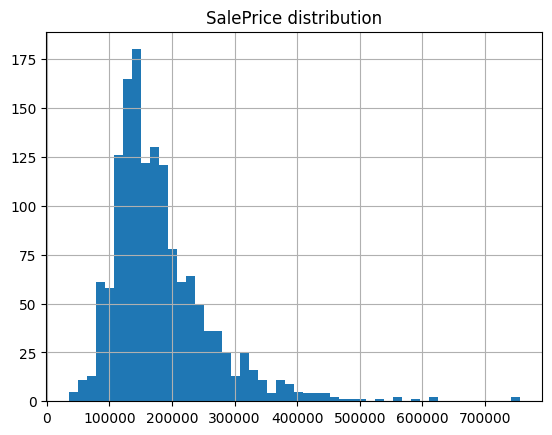

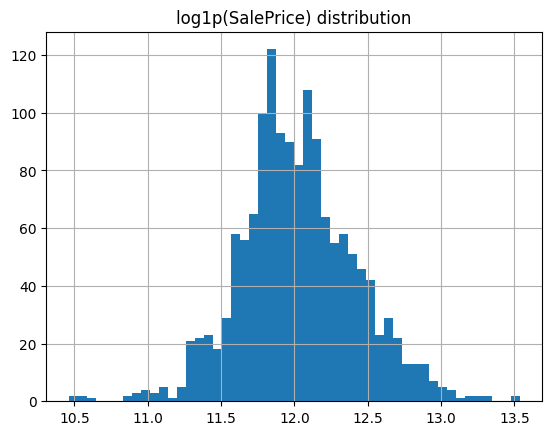

In [20]:

# Basic nulls overview
nulls = train.isna().sum().sort_values(ascending=False)
display(nulls.head(20))

# Target
assert 'SalePrice' in train.columns, "train.csv must have 'SalePrice' column"
train['log_SalePrice'] = np.log1p(train['SalePrice'])  # option for log target

fig = plt.figure()
train['SalePrice'].hist(bins=50)
plt.title('SalePrice distribution')
plt.show()

fig = plt.figure()
train['log_SalePrice'].hist(bins=50)
plt.title('log1p(SalePrice) distribution')
plt.show()


In [21]:

# Example feature engineering tailored to Ames:
# - TotalSF = GrLivArea + TotalBsmtSF
# - Age features: HouseAge, Remodeled (boolean), SinceRemodel
# - TotalBaths (Full + Half*0.5 + Basement baths)
# - QualityScore (e.g., OverallQual + KitchenQual/ExterQual ordinal maps)
#
# You can add/remove features in the 'featurize' function.

# Ordinal maps for selected quality columns (higher is better)
qual_map = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
exterqual_cols = ['ExterQual','KitchenQual','HeatingQC']

def featurize(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Safe fills
    for c in ['TotalBsmtSF','GrLivArea','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath']:
        if c in out.columns:
            out[c] = out[c].fillna(0)
    # TotalSF
    if set(['GrLivArea','TotalBsmtSF']).issubset(out.columns):
        out['TotalSF'] = out['GrLivArea'] + out['TotalBsmtSF']
    # Age features
    if 'YearBuilt' in out.columns and 'YrSold' in out.columns:
        out['HouseAge'] = out['YrSold'] - out['YearBuilt']
    if 'YearRemodAdd' in out.columns and 'YrSold' in out.columns:
        out['SinceRemodel'] = out['YrSold'] - out['YearRemodAdd']
        out['Remodeled'] = (out['YearRemodAdd'] != out['YearBuilt']).astype(int)
    # Baths
    for col in ['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath']:
        if col not in out.columns:
            out[col] = 0
    out['TotalBaths'] = out['FullBath'] + 0.5*out['HalfBath'] +                         out['BsmtFullBath'] + 0.5*out['BsmtHalfBath']
    # QualityScore
    for c in exterqual_cols:
        if c in out.columns:
            out[c] = out[c].map(qual_map).fillna(0)
    if set(['OverallQual','KitchenQual','ExterQual']).issubset(out.columns):
        out['QualityScore'] = out['OverallQual'] + out['KitchenQual'] + out['ExterQual']
    return out

# Wrap for sklearn ColumnTransformer with FunctionTransformer
featurizer = FunctionTransformer(featurize, feature_names_out='one-to-one')


In [22]:

# Identify column types
target = 'SalePrice'
drop_cols = [target] if target in train.columns else []
X_all = train.drop(columns=drop_cols, errors='ignore')
y_all = train[target]

# After featurize we will recompute columns, so we infer types on raw X
numeric_cols = [c for c in X_all.columns if pd.api.types.is_numeric_dtype(X_all[c])]
# Selected ordinal quality columns already mapped in featurize; treat as numeric afterwards

# Choose a small, interpretable categorical set for baseline
categorical_cols = [c for c in X_all.columns 
                    if (X_all[c].dtype == 'object') and c not in exterqual_cols]

numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler(with_mean=False))  # sparse-safe
])

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)


In [23]:

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(lambda yt, yp: rmse(yt, yp), greater_is_better=False)

# Toggle to run models on log-target; predictions will be expm1-transformed for metrics
USE_LOG_TARGET = True

def y_transform(y):
    return np.log1p(y) if USE_LOG_TARGET else y

def y_inverse(yhat):
    return np.expm1(yhat) if USE_LOG_TARGET else yhat

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)


## Experiment A — Baseline OLS (LinearRegression)

In [25]:
# ===== Minimal Experiment A: Plain Linear Regression on a few numeric features =====
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# --- Safety: define helpers here so this cell runs standalone ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

USE_LOG_TARGET = True  # set False if you want raw SalePrice
def y_transform(y):  # target -> model space
    return np.log1p(y) if USE_LOG_TARGET else y

def y_inverse(yhat):  # model space -> target
    return np.expm1(yhat) if USE_LOG_TARGET else yhat

# --- Pick a tiny, robust feature set (all numeric) ---
# These are common in Ames; we only keep the ones that actually exist in your train.csv
candidate_features = [
    "OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF",
    "FullBath", "YearBuilt"
]
features = [c for c in candidate_features if c in train.columns]
assert "SalePrice" in train.columns, "train must include SalePrice"
assert len(features) > 0, "None of the minimal features were found in your dataset."

# --- Build X, y (simple fillna) ---
X_all = train[features].copy().fillna(0)
y_all = train["SalePrice"].copy()

# --- CV loop (plain LinearRegression) ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
coefs = []

for tr_idx, te_idx in cv.split(X_all):
    X_tr, X_te = X_all.iloc[tr_idx], X_all.iloc[te_idx]
    y_tr, y_te = y_all.iloc[tr_idx].values, y_all.iloc[te_idx].values

    model = LinearRegression()
    model.fit(X_tr, y_transform(y_tr))
    preds = y_inverse(model.predict(X_te))
    scores.append(rmse(y_te, preds))
    coefs.append(model.coef_)

print(f"Exp A (MINIMAL OLS) CV RMSE: {np.mean(scores):.2f} +/- {np.std(scores):.2f}")
print("Features used:", features)

Exp A (MINIMAL OLS) CV RMSE: 52857.29 +/- 45890.74
Features used: ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']


## Experiment B — Ridge & Lasso (with simple alpha grid)

In [26]:

alphas = [0.1, 0.5, 1.0, 3.0, 10.0, 30.0, 100.0]
results_B = []

for reg_name, reg in [('Ridge', Ridge), ('Lasso', Lasso)]:
    for a in alphas:
        pipe = Pipeline(steps=[
            ('featurize', featurizer),
            ('preprocess', preprocess),
            ('reg', reg(alpha=a, random_state=SEED) if reg_name=='Lasso' else reg(alpha=a))
        ])
        fold_scores = []
        for tr_idx, te_idx in cv.split(train):
            X_tr, X_te = train.iloc[tr_idx].copy(), train.iloc[te_idx].copy()
            y_tr, y_te = y_transform(y_all.iloc[tr_idx].values), y_all.iloc[te_idx].values
            pipe.fit(X_tr, y_tr)
            preds = y_inverse(pipe.predict(X_te))
            fold_scores.append(rmse(y_te, preds))
        results_B.append((reg_name, a, np.mean(fold_scores), np.std(fold_scores)))

results_B_df = pd.DataFrame(results_B, columns=['Model','alpha','CV_RMSE','CV_STD']).sort_values('CV_RMSE')
display(results_B_df.head(10))


ValueError: The output generated by `func` have different column names than the ones provided by `get_feature_names_out`. Got output with columns names: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'log_SalePrice', 'TotalSF', 'HouseAge', 'SinceRemodel', 'Remodeled', 'TotalBaths', 'QualityScore'] and `get_feature_names_out` returned: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'log_SalePrice']. The column names can be overridden by setting `set_output(transform='pandas')` or `set_output(transform='polars')` such that the column names are set to the names provided by `get_feature_names_out`.

## Experiment C — Tree‑based: HistGradientBoostingRegressor

In [ ]:

# Use numeric-encoded features only for HGB to keep things fast: use OHE too via preprocess
model_C = Pipeline(steps=[
    ('featurize', featurizer),
    ('preprocess', preprocess),
    ('reg', HistGradientBoostingRegressor(random_state=SEED))
])

scores_C = []
for tr_idx, te_idx in cv.split(train):
    X_tr, X_te = train.iloc[tr_idx].copy(), train.iloc[te_idx].copy()
    y_tr, y_te = y_transform(y_all.iloc[tr_idx].values), y_all.iloc[te_idx].values
    model_C.fit(X_tr, y_tr)
    preds = y_inverse(model_C.predict(X_te))
    scores_C.append(rmse(y_te, preds))

print("Exp C (HGB) CV RMSE:", np.mean(scores_C), "+/-", np.std(scores_C))


## Pick the best model (manually for now) and refit on full train

In [ ]:

# Example: choose the best mean CV RMSE from the experiments above.
# For reproducibility, you can paste the best params here.
best_model = model_C  # <-- change to model_A or a specific Ridge/Lasso from Experiment B

# Fit on FULL training data
best_model.fit(train, y_transform(y_all.values))

# Create Kaggle submission on test.csv
test_pred = y_inverse(best_model.predict(test))
sub = pd.DataFrame({'Id': test['Id'], 'SalePrice': test_pred})
sub_path = DATA_DIR / 'submission.csv'
sub.to_csv(sub_path, index=False)
sub_path


## Optional: Local train/validation split (skip Kaggle)

In [ ]:

# If you don't want to submit to Kaggle, you can evaluate with a final holdout:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(train, y_all, test_size=0.2, random_state=SEED)
best_model.fit(X_tr, y_transform(y_tr.values))
preds = y_inverse(best_model.predict(X_te))
print("Holdout RMSE:", rmse(y_te.values, preds))



### Notes & Next Steps
- Try more engineered features (e.g., `TotalPorchSF`, `IsNew`, neighborhood medians, interaction terms).
- Replace `HistGradientBoostingRegressor` with `XGBRegressor` or `LGBMRegressor` if allowed in your environment.
- Tune hyperparameters using `GridSearchCV` or `RandomizedSearchCV`.
- Document each experiment: what changed, why, and the results.
